In [1]:
import os
import sys
import json
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
from keras import backend as K
from sklearn.metrics import precision_recall_fscore_support

In [45]:
with open("pos_amazon_cell_phone_reviews.json") as f:
    data = json.load(f)
data = data['root']
#print(len(data))
df_pos = pd.DataFrame(data)
summaries_positive = []
text_positive = []
for i in data:
    summaries_positive.append(i['summary'])
    text_positive.append(i['text'])
label = [1] * 108664
df_pos['label'] = label

In [86]:
df_pos2 = df_pos[0:5000]

In [118]:
with open("neg_amazon_cell_phone_reviews.json") as f:
    data = json.load(f)
summaries_negative=[]
text_negative=[]
data = data['root']
df_neg = pd.DataFrame(data)
for i in data:
    summaries_negative.append(i['summary'])
    text_negative.append(i['text'])
label = [0] * len(data)
df_neg['label'] = label
len(data)

13279

In [88]:
df_neg2 = df_neg[:5000]

In [89]:
df = df_pos2.append(df_neg2)

In [90]:
seed = 123

In [91]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
#X_train

In [92]:
tokenizer = Tokenizer()

In [93]:
summary = list(X_train['summary'])
summary_test = list(X_test['summary'])

In [94]:
tokenizer.fit_on_texts(summary)
vocab = tokenizer.word_index
vocab_counts = tokenizer.word_counts

In [95]:
sequences = tokenizer.texts_to_sequences(summary)
sequences_test = tokenizer.texts_to_sequences(summary_test)

In [96]:
sequences_test.index(max(sequences_test,key = lambda x : len(x)))
len(max(sequences_test,key = lambda x : len(x)))

19

In [97]:
len(vocab)

3426

In [98]:
pad_length = len(max(sequences, key = lambda x: len(x)))
#pad_length = 22

In [99]:
pad_length

22

In [100]:
new_X_train = pad_sequences(sequences, maxlen = pad_length)
new_X_test =  pad_sequences(sequences_test, maxlen = pad_length)

In [101]:
new_X_train

array([[   0,    0,    0, ...,    0,    0,  268],
       [   0,    0,    0, ..., 1638,   47,   42],
       [   0,    0,    0, ...,   36, 1176,  153],
       ..., 
       [   0,    0,    0, ...,    0,   96,  311],
       [   0,    0,    0, ...,    5,  446, 1170],
       [   0,    0,    0, ..., 3426,  187,  596]])

In [102]:
y_train.values

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [103]:
new_X_test

array([[   0,    0,    0, ...,    9,    7,    1],
       [   0,    0,    0, ...,    0, 2650,   29],
       [   0,    0,    0, ...,   49,   23,    5],
       ..., 
       [   0,    0,    0, ...,    0,  415,   32],
       [   0,    0,    0, ...,    4,   34,  111],
       [   0,    0,    0, ...,    0,    1,   36]])

In [104]:
new_Y_train = to_categorical(y_train)
new_Y_train
#len(vocab)
len(new_Y_train)

8000

In [105]:
new_Y_test = to_categorical(y_test)
len(new_Y_test)

2000

In [106]:
BASE_DIR = ''

GLOVE_DIR = os.path.join(BASE_DIR)

In [107]:
embeddings_index = {}

f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf8')

for line in f:

    values = line.split()

    word = values[0]

    coefs = np.asarray(values[1:], dtype='float32')

    embeddings_index[word] = coefs

f.close()



In [108]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [109]:
# prepare embedding matrix
MAX_NB_WORDS = 5000
num_words = min(MAX_NB_WORDS, len(vocab) + 1)
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in vocab.items():

    if i >= MAX_NB_WORDS:

        continue

    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:

        # words not found in embedding index will be all-zeros.

        embedding_matrix[i] = embedding_vector

In [110]:
num_words

3427

In [111]:
def precision(y_true, y_pred):
    """Precision metric.
 
    Only computes a batch-wise average of precision.
 
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

MODEL

In [112]:
model = Sequential()
model.add(Embedding(len(vocab) + 1, 100, input_length=pad_length))
model.add(LSTM(256,dropout=0.5,recurrent_dropout=0.2))
#model.add(LSTM(128,dropout=0.2,return_sequences=False))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall])

In [113]:
history = model.fit(new_X_train, new_Y_train, validation_split = 0.20, epochs = 10)

Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 30s - loss: 0.4614 - acc: 0.7812 - precision: 0.7819 - recall: 0.7802 - val_loss: 0.2856 - val_acc: 0.8806 - val_precision: 0.8802 - val_recall: 0.8812
Epoch 2/10
6400/6400 [==============================] - 28s - loss: 0.2356 - acc: 0.9170 - precision: 0.9171 - recall: 0.9169 - val_loss: 0.2583 - val_acc: 0.8966 - val_precision: 0.8958 - val_recall: 0.8975
Epoch 3/10
6400/6400 [==============================] - 29s - loss: 0.1712 - acc: 0.9416 - precision: 0.9409 - recall: 0.9423 - val_loss: 0.2756 - val_acc: 0.8978 - val_precision: 0.8976 - val_recall: 0.8981
Epoch 4/10
6400/6400 [==============================] - 28s - loss: 0.1334 - acc: 0.9535 - precision: 0.9535 - recall: 0.9536 - val_loss: 0.2778 - val_acc: 0.8991 - val_precision: 0.8988 - val_recall: 0.8994
Epoch 5/10
6400/6400 [==============================] - 28s - loss: 0.1101 - acc: 0.9617 - precision: 0.9616 - recall: 0

In [119]:
scores = model.evaluate(new_X_test, new_Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
y_pred = model.predict(new_X_test)
#y_pred
#precision([np.argmax(x) for x in new_Y_test], [np.argmax(x) for x in y_pred])
[p, r, f, _] = precision_recall_fscore_support([np.argmax(x) for x in new_Y_test], [np.argmax(x) for x in y_pred], average='binary')
#[[int(x[0].round()), int(x[1].round())] for x in y_pred]
#new_Y_test
#[np.argmax(x) for x in y_pred]
print("Precision: %.2f%%" % (p*100))
print("Recall: %.2f%%" % (r*100))
print("F-score: %.2f%%" % (f*100))

Accuracy: 90.83%
Precision: 89.86%
Recall: 91.85%
F-score: 90.85%


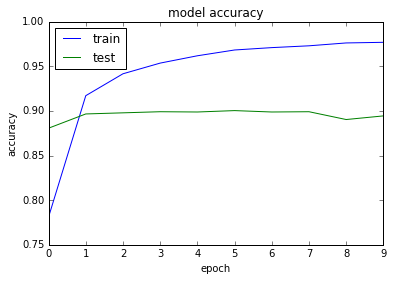

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

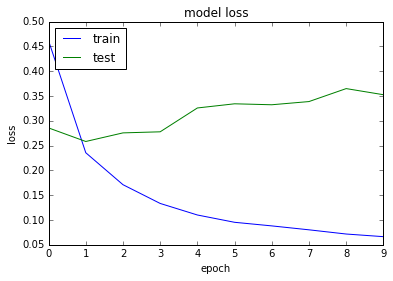

In [116]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [84]:
review = "Not that great. Don't buy"
review = [review]
#print(review)
to_check = tokenizer.texts_to_sequences(review)
to_check = pad_sequences(to_check, maxlen=pad_length)
to_check

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         2, 87,  1, 35, 20]])

In [85]:
predict_class = model.predict(to_check)
print(predict_class)
label = np.argmax(predict_class) 
print("Class : ", label)

if(label == 1):
    print("Positive")
else:
    print("Negative")


[[  9.99733031e-01   2.52798200e-04]]
Class :  0
Negative


In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 31, 100)           632200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 998,282
Trainable params: 998,282
Non-trainable params: 0
_________________________________________________________________


In [155]:
# Convolution

kernel_size = 5
filters = 128
pool_size = 4
model = Sequential()
model.add(Embedding(len(vocab) + 1, 32, input_length=pad_length))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))

model.add(LSTM(128))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall])

In [152]:
model.fit(new_X_train, new_Y_train, validation_split = 0.16, epochs = 5)

Train on 8064 samples, validate on 1536 samples
Epoch 1/5
8064/8064 [==============================] - 7s - loss: 0.6015 - acc: 0.6272 - precision: 0.6267 - recall: 0.6261 - val_loss: 0.5030 - val_acc: 0.7051 - val_precision: 0.7051 - val_recall: 0.7051
Epoch 2/5
8064/8064 [==============================] - 5s - loss: 0.4578 - acc: 0.7388 - precision: 0.7388 - recall: 0.7386 - val_loss: 0.4946 - val_acc: 0.7051 - val_precision: 0.7054 - val_recall: 0.7044
Epoch 3/5
8064/8064 [==============================] - 5s - loss: 0.4083 - acc: 0.7580 - precision: 0.7566 - recall: 0.7609 - val_loss: 0.5124 - val_acc: 0.7155 - val_precision: 0.7155 - val_recall: 0.7155
Epoch 4/5
8064/8064 [==============================] - 5s - loss: 0.3855 - acc: 0.7675 - precision: 0.7679 - recall: 0.7670 - val_loss: 0.5326 - val_acc: 0.7012 - val_precision: 0.7012 - val_recall: 0.7012
Epoch 5/5
8064/8064 [==============================] - 5s - loss: 0.3686 - acc: 0.7757 - precision: 0.7755 - recall: 0.7762 - va

In [120]:
d=[3000,6000,10000,33000]
a = [87.45,88.50,90.83,92.00]
p= [83.05,90.86,89.86,91.95]
r=[89.91,86.47,91.85,94.94]
f=[86.34,88.61,90.85,93.42]


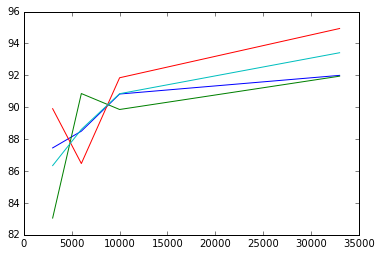

In [125]:

# red dashes, blue squares and green triangles
plt.plot(d, a , d , p , d , r , d, f,label='accuracy')
plt.show()